# Analýza textového hodnocení uživatelů Yelp datasetu
## Yelp dataset

Yelp dataset obsahuje textová hodnocení uživatelů jimi navštěvovaných podniků včetně škálového ohodnocení, kde škála je od 1 (nejhorší možné) do 5 (nejlepší možné). 

## Task

Cílem tohoto projektu je pomocí klasifikátorů:

-  **Logistic Regression**
-  **Decision Tree**
-  **Random forest**
-  **Multinomial Naive Bayes**

na základě textového hodnocení uživatele rozhodnout, které hodnocení na číselné škále mu uživatel přiřadil, případně zda bylo hodnocení pozitivní či negativní a efektivitu těchto klasifikátorů porovnat.

## Plan

1. Import potřebných knihoven
2. Nahrání a převedení Yelp datasetu do DataFrame
3. Rozhodnut, které features jsou potřebné pro další analýzu
4. Zredukovat a vybalancovat dataset (stejný počet zastoupení škálového hodnocení (1,2,3,4,5))
5. Odstranění nežádoucích znaků z textu, např. interpunkce, speciální znaky apod.
6. Odstranění tzv. ,,stop words" z textu jako [the, a, is, ...]
7. Vytvoření nového sloupce ohodocení v závislosti na číselném hodnocení, kde (1,2) = negativní, (4,5) = pozitivní
8. Vytvoření fuknce, které jsou jako vstupní parametry předány parametry datasetu (df, X, target) + parametr zpracování textu (ngram). Funkce zpracuje text do vektorů pomocí principu ,,bag of words", vyhodnotí pomocí klasifikátorů a ke každému vytvoří klasifikační skóre
9. Grafické porovnání klasifikátorů na základě datasetů a vstupních parametrů

## 1. Import knihoven

In [1]:
import json

import numpy as np
import pandas as pd

import re

from tqdm import tqdm

from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Nahrání a převedení Yelp datasetu do DataFrame
K tomuto slouží vytvořená funkce *yelp_data()*, které jsou předány vstupní parametry *file* což je systémová cesta k .json souboru a *stop*, který určuje, kolik záznamů (hodnocení uživatelů) se z datasetu nahraje. V tomto případě bylo zvoleno 150 000 záznamů, které byly převedeny do pandas DataFrame.

In [2]:
def yelp_data(file, stop):
    with open(file, encoding="utf-8") as f:
        counter = 0
        for line in f:
            counter += 1
            if counter == stop:
                break
            yield json.loads(line.rstrip())

In [3]:
review = yelp_data(file="yelp_academic_dataset_review.json", stop=150000)
df = pd.DataFrame.from_records(review)

## 3. Rozhodnutí, které features jsou vhodné/nevhodné pro další analýzu

Následující sloupce:

- **business_id**
- **date**
- **review_id**
- **user_id**

Byly vyhodonceny jako nepotřebné pro další analýzu a odstraněny z datasetu.

In [4]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,-MhfebM0QIsKt87iDN-FNw,0,2015-04-15 05:21:16,0,xQY8N_XvtGbearJ5X4QryQ,2.0,"As someone who has worked with many museums, I...",5,OwjRMXRC0KyPrIlcjaXeFQ
1,lbrU8StCq3yDfr-QMnGrmQ,0,2013-12-07 03:16:52,1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,I am actually horrified this place is still in...,1,nIJD_7ZXHq-FX8byPMOkMQ
2,HQl28KMwrEKHqhFrrDqVNQ,0,2015-12-05 03:18:11,0,LG2ZaYiOgpr2DK_90pYjNw,5.0,I love Deagan's. I do. I really do. The atmosp...,1,V34qejxNsCbcgD8C0HVk-Q
3,5JxlZaqCnk1MnbgRirs40Q,0,2011-05-27 05:30:52,0,i6g_oA9Yf9Y31qt0wibXpw,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0,ofKDkJKXSKZXu5xJNGiiBQ
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4.0,"Oh happy day, finally have a Canes near my cas...",0,UgMW8bLE0QMJDCkQ1Ax5Mg


In [5]:
df.drop(["business_id", "date", "review_id", "user_id"], axis=1, inplace=True)

## 4. Balancování datasetu

Pro další analýzu je žádoucí, aby byla všechna hodnocení ve smyslu škály zastoupena v datasetu rovnoměrně. Toto je upravitelné nastavením proměnných *start_point* a *end_point*.

V tomto případě bude obsahovat dataset **df1**:

- **10 000 vzorků s hodnocením 1**
- **10 000 vzorků s hodnocením 2**
- **10 000 vzorků s hodnocením 3**
- **10 000 vzorků s hodnocením 4**
- **10 000 vzorků s hodnocením 5**

Celkem tedy dataset **df1** obsahuje 50 000 vzorků (hodnocení). Dále bylo zkontrolováno, zda některé z hodnocení není nevyplněné a bylo resetováno indexování datasetu.

In [6]:
df["stars"].value_counts()

5.0    65965
4.0    34180
1.0    20658
3.0    16819
2.0    12377
Name: stars, dtype: int64

In [7]:
start_point = 0
end_point = 10000

df1 = pd.DataFrame()
for i in range(1,6):
    df1 = df1.append(df[df["stars"] == i][start_point:end_point])

In [8]:
df1["text"].isnull().sum()

0

In [9]:
df1.sort_index(inplace=True)

In [10]:
df1["stars"].value_counts()

3.0    10000
5.0    10000
4.0    10000
1.0    10000
2.0    10000
Name: stars, dtype: int64

## 5. Odstranění nežádoucích znaků z textu

Pomocí knihovny **regular expressions** byly odstraněny nežádoucí znaky (interpunkce, speciální znaky apod.) z textů hodnocení a veškerý text byl nastaven do stavu *lower case*. 

Srovnání textu před odstranením nežádoucích znaků a po je uvedeno níže.

In [11]:
REPLACE_NSPACE = re.compile("[\n.;:!'?*,\"()0-9#&@$/-]") 

def text_preprocess(review):
    review = [REPLACE_NSPACE.sub("", line.lower()) for line in review]
    return review

In [12]:
df1["Cleaned_text"] = text_preprocess(df1["text"])

In [238]:
print("\033[1m" + "Původní text:")
print("\033[0m" + "\n")
print(df1["text"][0])
print("\n")
print("\033[1m" + "Text bez nežádoucích znaků:")
print("\033[0m" + "\n")
print(df1["Cleaned_text"][0])

Původní text:


As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!

Tucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It's what real estate agents would call "cozy" or "charming" - basically any euphemism for small.

That being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:

* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.
* it's not kid friendly at all. Seriously, don't bring them.
* the security is not trained properly for the show. When the curating and design teams collaborate for exhibitions, there is a definite flow. That means visitors should view th

## 6. Odstranění ,,stop words"
Dále byly z textů hodnocení odstraněná ,,stop words" z toho důvodu, že pro analýzu sentimentu nejsou významná a pro redukci vstupních dat klasifikátorů. 

Porovnání textů před a po odstranění je uvedeno níže.

In [14]:
en_stop_words = stopwords.words("english")
def remove_stopwords(corpus):
    cleared = []
    for review in corpus:
        cleared.append(' '.join([word for word in review.split() if word not in en_stop_words]))
    return cleared

In [15]:
df1["Cleaned_text_stwo"] = remove_stopwords(df1["Cleaned_text"])

In [16]:
print("\033[1m" + "Původní text:")
print("\033[0m" + "\n")
print(df1["Cleaned_text"][0])
print("\n")
print("\033[1m" + "Text bez stop words:")
print("\033[0m" + "\n")
print(df1["Cleaned_text_stwo"][0])

Původní text:


as someone who has worked with many museums i was eager to visit this gallery on my most recent trip to las vegas when i saw they would be showing infamous eggs of the house of faberge from the virginia museum of fine arts vmfa i knew i had to gotucked away near the gelateria and the garden the gallery is pretty much hidden from view its what real estate agents would call cozy or charming  basically any euphemism for smallthat being said you can still see wonderful art at a gallery of any size so why the two s you ask let me tell you pricing for this while relatively inexpensive for a las vegas attraction is completely over the top for the space and the amount of art you can fit in there it is a bit much its not kid friendly at all seriously dont bring them the security is not trained properly for the show when the curating and design teams collaborate for exhibitions there is a definite flow that means visitors should view the art in a certain sequence whether it be by

## 7. Rozdělení datasetu pro klasifikace

Klasifikace byla provedena na celkem 3 modifikovaných datasetech:

1. **df1**: Původní dataset, kde je každé hodnocení od 1 do 5 zastoupeno 10 000 vzorky


2. **df_posneg**: Modifikovaný dataset, kde pomocí funkce *posneg_func()* byl vytvořen nový sloupec *"positive"* s hodnoutou 1 nebo 0, která byla přiřazována následovně: Je-li uživatelské hodnocení 1 nebo 2 je hodnota *"positive"* rovna 0, naopak je-li hodnocení 4 nebo 5, je přiřazena k hodnotě *"positive"* hodnota 1. Uživatelské hodnocení 3 bylo z datasetu odstraněno.


3. **df_binary15**: Obsahuje jen ta hodnocení, která obdržela 1 nebo 5, zbylá byla z datasetu odstarněna

In [17]:
df_posneg = df1.drop(df1[df1["stars"] == 3].index)
df_posneg.name = "df_posneg"
df_posneg["stars"].value_counts()

5.0    10000
4.0    10000
1.0    10000
2.0    10000
Name: stars, dtype: int64

In [18]:
def posneg_func(df):
    if df["stars"] == 4 or df["stars"] == 5:
        value = 1
    else:
        value = 0
    return value

In [19]:
df_posneg["positive"] = df_posneg.apply(posneg_func, axis=1)

In [20]:
df_binary15 = df_posneg.drop(df_posneg[df_posneg["stars"] == 2].index)
df_binary15 = df_binary15.drop(df_binary15[df_binary15["stars"] == 4].index)

In [21]:
df_binary15 = df_binary15.drop("positive", axis=1)

In [22]:
df_binary15["stars"].value_counts()

5.0    10000
1.0    10000
Name: stars, dtype: int64

In [23]:
df_posneg = df_posneg.drop("stars", axis=1)

## 8. Vytvoření funkce pro rozdělení dat na testovací, trénovací, případně validační a testování klasifikátorů

Níže je definován slovník s klasifikátory a jejich názvy.

**Funkce *classify()***


Tato funkce slouží pro zpracování datasetu, převedení textů na vstupní vektory pomocí principu ,,bag of words", rozdělení dat na trénovací, testovací a validační, následné analýze pomocí klasifikátorů a k zobrazení klasifikačních reportů.

Jako vstupní parametry jsou předávány funkci:

- **df** - dataset


- **input_data** - vstupní data


- **target** - target


- **ngram_range** - parametr pro slovní spojení. Zadává se pomocí tuple a slouží jako rozsah. Například (1,1) by rozdělilo string *"výborný oběd"* na *"výborný"* a *"oběd"*, (1,2) by pak spojení rozdělilo na *"výborný"*, *"oběd"*, a *"výborný oběd"*, (2,2) jen na *"výborný oběd"*.


- **test_prop** - float od 0 do 1 sloužící k určení, jak velká část dat bude pro testování a jak velká pro trénování 


Funkce nejprve zamíchá řádky datasetu a resetuje indexy. Dále data rozdělí na trénovací a testovancí. Textová hodnocení jsou dále převedena na vektory pomocí *CountVectorizer*. Následně jsou data znovu rozdělena na trénovací a validnační. Poté jsou klasifikována pomocí klasifikátorů. 

In [24]:
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.01),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=10),
    "Multinomial NB": MultinomialNB()
}

results = pd.DataFrame(columns=["Logistic Regression", 
                                "Decision Tree",
                                "Random Forest",
                                "Multinomial NB"])

df1.name = "Multiclass"
df_posneg.name = "Binary-posneg"
df_binary15.name = "Binary-15"

In [25]:
def classify(df, input_data, target, ngram_range=(1,1), test_prop=0.2):
    
    dataset_name = df.name
    
    df = shuffle(df)
    df = df.reset_index(drop=True)
    
    X = df[input_data]
    y = df[target]
    
    test_prop = test_prop
    
    X_train, X_test = X[:int(len(X)*(1-test_prop))], X[int(len(X)*(1-test_prop)):]
    y_train, y_test = y[:int(len(X)*(1-test_prop))], y[int(len(X)*(1-test_prop)):]
    
    cv = CountVectorizer(ngram_range=ngram_range)
    cv.fit(X_train)
    X_train = cv.transform(X_train)
    X_test = cv.transform(X_test)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_prop)
    
    result_dict = {}
    for name in classifiers:
        classifiers[name].fit(X_train,y_train)
        predictions = classifiers[name].predict(X_test)
        score = accuracy_score(y_test, predictions)
        result_dict.update({name: [dataset_name, input_data, score, str(ngram_range)]})
        
    return result_dict

Následující výpočet trvá poměrně dlouhou dobu. Výsledky proto byly uloženy jako DataFrame *Classification_results.plk* a lze je nahrát odkomentováním řádku níže. 

In [236]:
#res = pd.read_pickle("./Classification_results.plk")
#res.head(10)

In [26]:
datasets = [df1, df_posneg, df_binary15]
inputs_data = ["Cleaned_text", "Cleaned_text_stwo"]
targets = ["positive", "stars"]
ngrams = [(1,1), (2,2)]

results = pd.DataFrame()

for dataset in tqdm(datasets):
    for inp in inputs_data:
        for target in targets:
            for ngram in tqdm(ngrams):
                try:
                    print("Working on {} dataset with {} as input. Target comlumn is '{}', CountVectorizer with {} ngrams.".format(dataset.name, inp, target, str(ngram)))
                    result_dict = classify(df=dataset, input_data=inp, target=target, ngram_range=ngram)
                    results = results.append(pd.DataFrame.from_dict(result_dict, orient="index"))
                except KeyError:
                    print("Skipped! Target column name '{}' is not in dataset {}".format(target, dataset.name))
                    continue

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Multiclass dataset with Cleaned_text as input. Target comlumn is 'positive', CountVectorizer with (1, 1) ngrams.
Skipped! Target column name 'positive' is not in dataset Multiclass
Working on Multiclass dataset with Cleaned_text as input. Target comlumn is 'positive', CountVectorizer with (2, 2) ngrams.
Skipped! Target column name 'positive' is not in dataset Multiclass



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Multiclass dataset with Cleaned_text as input. Target comlumn is 'stars', CountVectorizer with (1, 1) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:42<02:42, 162.67s/it]

Working on Multiclass dataset with Cleaned_text as input. Target comlumn is 'stars', CountVectorizer with (2, 2) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Multiclass dataset with Cleaned_text_stwo as input. Target comlumn is 'positive', CountVectorizer with (1, 1) ngrams.
Skipped! Target column name 'positive' is not in dataset Multiclass
Working on Multiclass dataset with Cleaned_text_stwo as input. Target comlumn is 'positive', CountVectorizer with (2, 2) ngrams.
Skipped! Target column name 'positive' is not in dataset Multiclass



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Multiclass dataset with Cleaned_text_stwo as input. Target comlumn is 'stars', CountVectorizer with (1, 1) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:52<02:52, 172.08s/it]

Working on Multiclass dataset with Cleaned_text_stwo as input. Target comlumn is 'stars', CountVectorizer with (2, 2) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-posneg dataset with Cleaned_text as input. Target comlumn is 'positive', CountVectorizer with (1, 1) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 50%|██████████████████████████████████████████                                          | 1/2 [01:13<01:13, 73.25s/it]

Working on Binary-posneg dataset with Cleaned_text as input. Target comlumn is 'positive', CountVectorizer with (2, 2) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-posneg dataset with Cleaned_text as input. Target comlumn is 'stars', CountVectorizer with (1, 1) ngrams.
Skipped! Target column name 'stars' is not in dataset Binary-posneg
Working on Binary-posneg dataset with Cleaned_text as input. Target comlumn is 'stars', CountVectorizer with (2, 2) ngrams.
Skipped! Target column name 'stars' is not in dataset Binary-posneg



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-posneg dataset with Cleaned_text_stwo as input. Target comlumn is 'positive', CountVectorizer with (1, 1) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 50%|██████████████████████████████████████████                                          | 1/2 [00:58<00:58, 58.51s/it]

Working on Binary-posneg dataset with Cleaned_text_stwo as input. Target comlumn is 'positive', CountVectorizer with (2, 2) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-posneg dataset with Cleaned_text_stwo as input. Target comlumn is 'stars', CountVectorizer with (1, 1) ngrams.
Skipped! Target column name 'stars' is not in dataset Binary-posneg
Working on Binary-posneg dataset with Cleaned_text_stwo as input. Target comlumn is 'stars', CountVectorizer with (2, 2) ngrams.
Skipped! Target column name 'stars' is not in dataset Binary-posneg



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-15 dataset with Cleaned_text as input. Target comlumn is 'positive', CountVectorizer with (1, 1) ngrams.
Skipped! Target column name 'positive' is not in dataset Binary-15
Working on Binary-15 dataset with Cleaned_text as input. Target comlumn is 'positive', CountVectorizer with (2, 2) ngrams.
Skipped! Target column name 'positive' is not in dataset Binary-15



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-15 dataset with Cleaned_text as input. Target comlumn is 'stars', CountVectorizer with (1, 1) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 50%|██████████████████████████████████████████                                          | 1/2 [00:18<00:18, 18.57s/it]

Working on Binary-15 dataset with Cleaned_text as input. Target comlumn is 'stars', CountVectorizer with (2, 2) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-15 dataset with Cleaned_text_stwo as input. Target comlumn is 'positive', CountVectorizer with (1, 1) ngrams.
Skipped! Target column name 'positive' is not in dataset Binary-15
Working on Binary-15 dataset with Cleaned_text_stwo as input. Target comlumn is 'positive', CountVectorizer with (2, 2) ngrams.
Skipped! Target column name 'positive' is not in dataset Binary-15



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Working on Binary-15 dataset with Cleaned_text_stwo as input. Target comlumn is 'stars', CountVectorizer with (1, 1) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 50%|██████████████████████████████████████████                                          | 1/2 [00:16<00:16, 16.52s/it]

Working on Binary-15 dataset with Cleaned_text_stwo as input. Target comlumn is 'stars', CountVectorizer with (2, 2) ngrams.


C:\Users\jirka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:26:11<00:00, 2102.97s/it]


## 9. Grafické porovnání klasifikátorů na základě datasetů a vstupních parametrů
Následující řádky upravují výsledný DataFrame (inedexování, pojemnování sloupců) v případě, že uživatel nenahraje uživatel nenahraje výsledky z *Classification_results.plk*.


Následně jsou výsledky rozděleny do dvou DataFrame:


- **res_clnd** - Obsahuje výsledky klasifikátorů pro text, který obsahuje *stop words*


- **res_clnd** - Obsahuje výsledky klasifikátorů pro text, který neobsahuje *stop words*

Dále jsou výsledky zobrazeny pomocí **seaborn** knihovny a je vytvořen report srovnávající efektivitu algoritmů při různých nastaveních.

In [ ]:
results.columns = ["Classification", "Text", "Accuracy", "ngram"]
results.head(10)

In [174]:
results.index = [x for x in range(len(results1))]
res = results

In [232]:
#Uložení DataFrame
res.to_pickle("./Classification_results.plk")

In [199]:
res_clnd = res[res["Text"]=="Cleaned_text"]
res_clndstwo = res[res["Text"]=="Cleaned_text_stwo"]

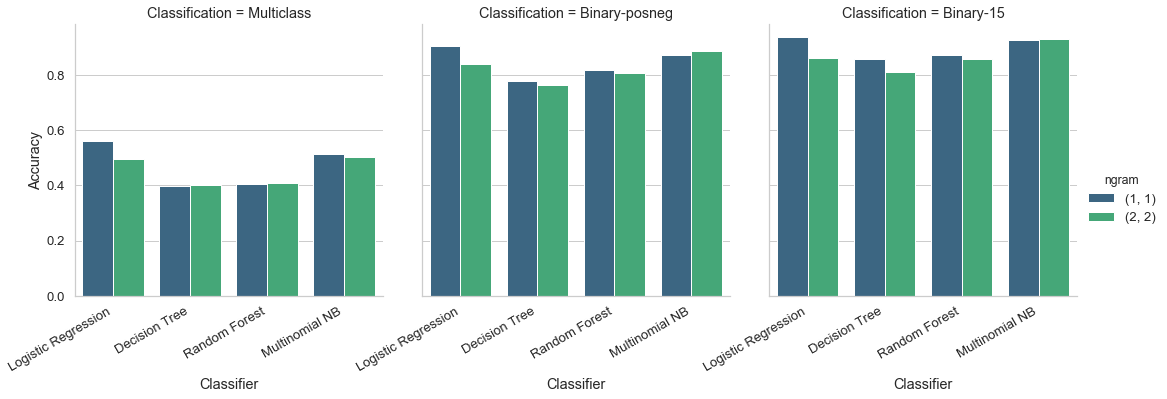

In [194]:
sns.set(style="whitegrid", font_scale=1.2)

plot = sns.catplot(x="Classifier", y="Accuracy", col="Classification", 
            hue="ngram", data=res_clndstwo, height=5, kind="bar", palette="viridis")

plot.set_xticklabels(rotation=30, horizontalalignment='right')

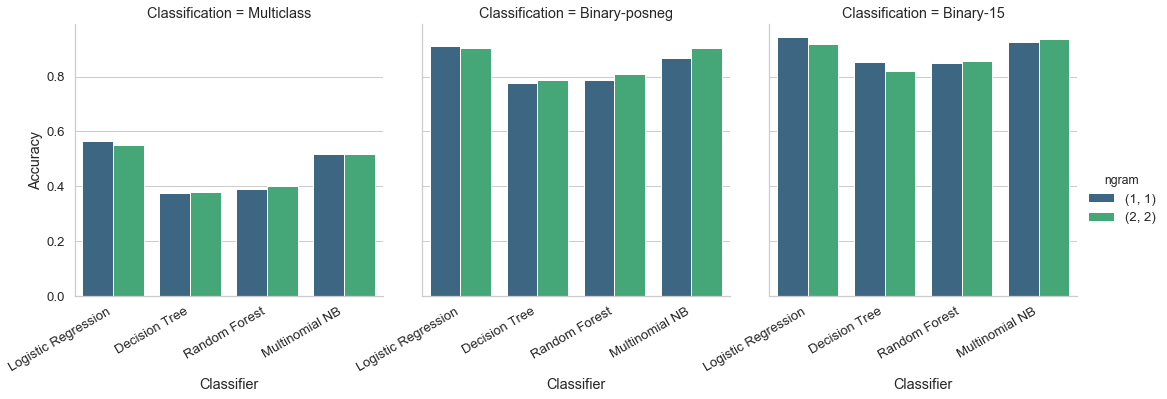

In [242]:
plot = sns.catplot(x="Classifier", y="Accuracy", col="Classification", 
            hue="ngram", data=res_clnd, height=5, kind="bar", palette="viridis")

plot.set_xticklabels(rotation=30, horizontalalignment='right')

## Report efektivity algorimtů

Rozdělení DataFrame dle charakteru klasifikace pro srovnávací report.

*Připomenutí:*

- **df_multi:** Výsledky klasifikátorů při klasifikaci hodnocení do tříd 1,2,3,4,5


- **df_binary_15:** Výsledky klasifikátorů při klasifikaci hodnocení do dvou tříd 1 nebo 5


- **df_binary_posneg:** Výsledky klasifikátorů při klasifikaci hodnocení do dvou tříd positive/negative (0/1), kde uživatelské hodnocení 1 a 2 je labelováno jako negative (positive = 0) a hodnocení 4, 5 jako positive (positive = 1) 

In [214]:
df_multi = res[res["Classification"] == "Multiclass"]
df_binary_15 = res[res["Classification"] == "Binary-15"]
df_binary_posneg = res[res["Classification"] == "Binary-posneg"]

In [240]:
print("\033[1m" + "Performance report")
print("\n")

print("\033[1m" + "Multiclass dataset - Classifier with the lowest performance" + "\033[0m")
print(df_multi[df_multi["Accuracy"] == df_multi["Accuracy"].min()])
print("\n")

print("\033[1m" +"Multiclass dataset - Classifier with the highest performance" + "\033[0m")
print(df_multi[df_multi["Accuracy"] == df_multi["Accuracy"].max()])
print("\n")

print("\033[1m" + "Binary-15 dataset - Classifier with the lowest performance" + "\033[0m")
print(df_binary_15[df_binary_15["Accuracy"] == df_binary_15["Accuracy"].min()])
print("\n")

print("\033[1m" + "Binary-15 dataset - Classifier with the highest performance" "\033[0m")
print(df_binary_15[df_binary_15["Accuracy"] == df_binary_15["Accuracy"].max()])
print("\n")

print("\033[1m" + "Binary-15 Pos-Neg - Classifier with the lowest performance" + "\033[0m")
print(df_binary_posneg[df_binary_posneg["Accuracy"] == df_binary_posneg["Accuracy"].min()])
print("\n")

print("\033[1m" + "Binary-15 Pos-Neg - Classifier with the highest performance" + "\033[0m")
print(df_binary_posneg[df_binary_posneg["Accuracy"] == df_binary_posneg["Accuracy"].max()])

Performance report


Multiclass dataset - Classifier with the lowest performance
  Classification          Text  Accuracy   ngram     Classifier
1     Multiclass  Cleaned_text    0.3751  (1, 1)  Decision Tree


Multiclass dataset - Classifier with the highest performance
  Classification          Text  Accuracy   ngram           Classifier
0     Multiclass  Cleaned_text    0.5648  (1, 1)  Logistic Regression


Binary-15 dataset - Classifier with the lowest performance
   Classification               Text  Accuracy   ngram     Classifier
45      Binary-15  Cleaned_text_stwo   0.80825  (2, 2)  Decision Tree


Binary-15 dataset - Classifier with the highest performance
   Classification          Text  Accuracy   ngram           Classifier
32      Binary-15  Cleaned_text    0.9445  (1, 1)  Logistic Regression


Binary-15 Pos-Neg - Classifier with the lowest performance
   Classification               Text  Accuracy   ngram     Classifier
29  Binary-posneg  Cleaned_text_stwo     0.763  (2, 

# Výsledky

## df_multi

- Nejhorší přesnosti **37.51%** na tomto datasetu dosáhl algoritmus **Decision Tree** na textu s neodstraněnými stop words a s nastavením ngram = (1,1) pro CountVectorizer.


- Nejlepší přesnosti **56.48%** na tomto datasetu dosáhl algoritmus **Logistic Regression** na textu s neodstraněnými stop words a s nastavením ngram = (1,1) pro CountVectorizer.

## df_binary_15

- Nejhorší přesnosti **80.83%** na tomto datasetu dosáhl algoritmus **Decision Tree** na textu s odstraněnými stop words a s nastavením ngram = (2,2) pro CountVectorizer.


- Nejlepší přesnosti **94.45%** na tomto datasetu dosáhl algoritmus **Logistic Regression** na textu s neodstraněnými stop words a s nastavením ngram = (1,1) pro CountVectorizer.

## df_binary_posneg

- Nejhorší přesnosti **76.3%** na tomto datasetu dosáhl algoritmus **Decision Tree** na textu s odstraněnými stop words a s nastavením ngram = (2,2) pro CountVectorizer.


- Nejlepší přesnosti **90.99%** na tomto datasetu dosáhl algoritmus **Logistic Regression** na textu s neodstraněnými stop words a s nastavením ngram = (1,1) pro CountVectorizer.
